In [4]:
!pip install gdown

In [5]:
import gdown
import pandas as pd
import random
import json
import numpy as np
import networkx as nx

In [6]:
gdown.download('https://drive.google.com/file/d/17NBXx6l_6znStM52RJOKKKlxnHigavzq/view', fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=17NBXx6l_6znStM52RJOKKKlxnHigavzq
From (redirected): https://drive.google.com/uc?id=17NBXx6l_6znStM52RJOKKKlxnHigavzq&confirm=t&uuid=15dbfa11-7951-4076-b35e-d7ba9355acf7
To: /kaggle/working/hackathon_objects.tar.gz
100%|██████████| 1.15G/1.15G [00:08<00:00, 135MB/s] 


'hackathon_objects.tar.gz'

In [7]:
gdown.download('https://drive.google.com/file/d/1WGODJxN91z98TsR6Pt4lTkGtJwBglMGm/view?usp=drive_link', fuzzy = True)

Downloading...
From: https://drive.google.com/uc?id=1WGODJxN91z98TsR6Pt4lTkGtJwBglMGm
To: /kaggle/working/train_pairs_ext.parquet
100%|██████████| 7.12M/7.12M [00:00<00:00, 200MB/s]


'train_pairs_ext.parquet'

In [8]:
!ls ../input/my-params

contrastive_ozon_cat.pt   contrastive_ozon_more_pics.pt
contrastive_ozon_last.pt


In [9]:
!tar -xvzf hackathon_objects.tar.gz

files/
files/metric.py
files/submission_example.csv
files/datasets/
files/datasets/test_data.parquet
files/datasets/train_data.parquet
files/datasets/train_pairs_w_target.parquet
files/datasets/test_for_participants.csv


In [10]:
goods_data = pd.read_parquet('files/datasets/train_data.parquet')

#goods_pairs = pd.read_parquet('files/datasets/train_pairs_w_target.parquet')

In [11]:
tr = goods_data.categories.apply(lambda x: eval(x))
trim = pd.DataFrame(tr.to_list()).rename(columns={str(i):f'cat_{i}' for i in range(1, 5)})
st = trim.drop_duplicates().reset_index(drop = True).rename(columns={str(i):f'cat_{i}' for i in range(1, 5)})
dikt_cat_2= {i: j for i, j in zip(st.cat_2.unique(), range(1, st.cat_2.nunique()+1))}
dikt_cat_3= {i: j for i, j in zip(st.cat_3.unique(), range(1, st.cat_3.nunique()+1))}
dikt_cat_4= {i: j for i, j in zip(st.cat_4.unique(), range(1, st.cat_4.nunique()+1))}
st['cat_2'] = st.cat_2.map(dikt_cat_2)
st['cat_3'] = st.cat_3.map(dikt_cat_3)
st['cat_4'] = st.cat_4.map(dikt_cat_4)
trim['cat_2_en'] = trim.cat_2.map(dikt_cat_2)
trim['cat_3_en'] = trim.cat_3.map(dikt_cat_3)
trim['cat_4_en'] = trim.cat_4.map(dikt_cat_4)
G = nx.Graph()
nodes = [0]
edges = []
lz = []
for _, row in st.iterrows():

    cat_1, cat_2, cat_3, cat_4 = row['cat_1'], row['cat_2'], row['cat_3'], row['cat_4']
    cat_2 = int('1'+('0'+str(cat_2))[-2:])
    if cat_2 not in nodes:
        nodes.append(cat_2)
        edges.append((0, cat_2))
    cat_3 = int(str(cat_2)+('00'+str(cat_3))[-3:])
    if cat_3 not in nodes:
        nodes.append(cat_3)
        edges.append((cat_2, cat_3))
    cat_4 = int(str(cat_2)+str(cat_3)+('00'+str(cat_4))[-3:])
    if cat_4 not in nodes:
        nodes.append(cat_4)
        edges.append((cat_3, cat_4))
    lz.append(cat_4)
G.add_nodes_from(nodes)
G.add_edges_from(edges)
st['encoder'] = lz
trim = trim.merge(st, left_on = ['cat_2_en', 'cat_3_en', 'cat_4_en'], right_on = ['cat_2', 'cat_3', 'cat_4'], how = 'left')
goods_data['cat_encoded'] = trim['encoder']

In [12]:
def symm_pairs(df):
    # todo: complete cliques of goods
    
    df2 = df.copy()
    cols = ["variantid1", "variantid2"]
    for c in cols:
        if c not in df2.columns:
            raise UserWarning
    df2 = df2.rename(columns={cols[0]: cols[1], cols[1]: cols[0]})
    return pd.concat([df, df2]).drop_duplicates()

In [13]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader


class ContrastiveDataset(Dataset):
    def __init__(self, original_dataset, pairs_dataset, embedding_columns, mode = True):
       # self.original_dataset = original_dataset.set_index('variantid')
        self.pairs_dataset = pairs_dataset
        self.embedding_columns = embedding_columns
        self.dataset = None
        self.mode = mode
        if self.mode:
            self.prepare_dataset()

        else:
            self.prepare_test_dataset()
        self.data = self.prepare_data(original_dataset.set_index('variantid'))
        

    def prepare_dataset(self):
        neg_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==0.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        pos_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==1.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        self.dataset = pos_pairs.merge(neg_pairs, how = 'outer', left_index = True, right_index = True, suffixes = ['_pos', '_neg'])
        sol = pd.Series(np.where(self.dataset.variantid2_pos.notnull(), self.dataset.variantid2_pos, pd.Series(self.dataset.index).apply(lambda x: [x])))
        self.dataset['variantid2_pos'] = sol.set_axis(self.dataset.index)
        ld = pd.Series(self.dataset.index).sample(frac = 1).apply(lambda x: [x])
        sol = pd.Series(np.where(self.dataset.variantid2_neg.notnull(), self.dataset.variantid2_neg, ld))
        self.dataset['variantid2_neg'] = sol.set_axis(self.dataset.index)
        self.dataset = self.dataset.reset_index()

        
    def prepare_data(self, original_dataset):
        def func(x):
            lz = [torch.tensor(x['main_pic_embeddings_resnet_v1'][0]), torch.tensor(x['name_bert_64'])]#, torch.tensor(x['category_encoded']).unsqueeze(dim =0)]
            return torch.cat(lz, axis = 0)
        
        return original_dataset.apply(lambda x: func(x), axis =1)
    
    def prepare_test_dataset(self):
        self.dataset = self.pairs_dataset[['variantid1']].drop_duplicates().reset_index(drop=True)



    def __getitem__(self, index):
        original_idx = self.dataset.loc[index].variantid1
        if self.mode:
            positive_idx = self.dataset.loc[index].variantid2_pos
            negative_idx = self.dataset.loc[index].variantid2_neg
            if len(positive_idx)>1:
                val = np.random.choice(len(positive_idx), 1)[0]
                positive_idx = positive_idx[val]
            else:
                positive_idx = positive_idx[0]
            if len(negative_idx)>1:
                val = np.random.choice(len(negative_idx), 1)[0]
                negative_idx = negative_idx[val]
            else:
                negative_idx = negative_idx[0]
            positive_pair = self.data.loc[positive_idx]
            negative_pair = self.data.loc[negative_idx]
            original_data = self.data.loc[original_idx]
          #  print(original_data)
            return original_data, positive_pair, negative_pair, original_idx
        else:
            original_data = self.data.loc[original_idx]
            return original_data, original_idx


    def __len__(self):
        return len(self.dataset)



# Actual data

In [14]:
goods_pairs_ext = pd.read_parquet('train_pairs_ext.parquet')
#symm_goods_pairs = symm_pairs(goods_pairs)
symm_goods_pairs_ext = symm_pairs(goods_pairs_ext)

In [10]:
# goods_data["cat3"] = goods_data["categories"].apply(lambda x: json.loads(x)["3"])
# cat3_counts = goods_data["cat3"].value_counts().to_dict()
# goods_data["cat3_grouped"] = goods_data["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")
# dikt_categories= {i: j for i, j in zip(goods_data.cat3_grouped.unique(), np.arange(goods_data.cat3_grouped.nunique())/goods_data.cat3_grouped.nunique())}
# goods_data['category_encoded'] = goods_data.cat3_grouped.map(dikt_categories)

In [15]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64', 'category']

contrastive_dataset = ContrastiveDataset(goods_data, symm_goods_pairs_ext, embedding_columns, mode= True)
contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=128, shuffle=True, drop_last= False, num_workers = 2)
next(iter(contrastive_dataloader))[0].shape

torch.Size([128, 192])

In [16]:
yt = next(iter(contrastive_dataloader))
yt[0].shape, yt[1].shape, yt[2].shape

(torch.Size([128, 192]), torch.Size([128, 192]), torch.Size([128, 192]))

# Basic train example

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [18]:
#!g1.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
#!g1.1
class ContrastiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(ContrastiveModel, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, embedding_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, dim=1)
    distance_negative = torch.norm(anchor - negative, dim=1)
    loss = torch.clamp(distance_positive - distance_negative + margin, min=0.0).mean()
    return loss

# Example parameters
input_size = 192
hidden_size = 64
embedding_size = 32
learning_rate = 0.001
num_epochs = 10

# Create an instance of the model
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
def train(model, contrastive_dataloader, optimizer, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        
        for original_data, positive_pair, negative_pair, _ in tqdm(contrastive_dataloader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            anchor = model(original_data.to(device))
            positive = model(positive_pair.to(device))
            negative = model(negative_pair.to(device))
            
            # Compute the triplet loss
            loss = triplet_loss(anchor, positive, negative)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
    #     print(loss.item())
            total_loss += loss.item()
        
        average_loss = total_loss / len(contrastive_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")


In [70]:
# Create an instance of the model
learning_rate = 0.001
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
learning_rate = 0.0001
num_epochs = 10
train(model, contrastive_dataloader, optimizer, num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1695 [00:00<?, ?it/s]

Epoch [1/10], Average Loss: 0.1548


  0%|          | 0/1695 [00:00<?, ?it/s]

Epoch [2/10], Average Loss: 0.1551


  0%|          | 0/1695 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(), 'contrastive_ozon_last.pt')

In [75]:
from IPython.display import FileLink
FileLink(r'contrastive_ozon_cat.pt')

/kaggle/working/contrastive_ozon_cat.pt

In [20]:
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)
model.load_state_dict(torch.load('../input/my-params/contrastive_ozon.pt'))

<All keys matched successfully>

In [21]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, _, _, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, contrastive_dataloader)

        


  0%|          | 0/3569 [00:00<?, ?it/s]

In [22]:
embed = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})
classif = goods_pairs_ext.merge(embed, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])
classif = classif.merge(embed, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])
classif.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [139]:
classif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468759 entries, 0 to 468758
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   target      468759 non-null  int64 
 1   variantid1  468759 non-null  int64 
 2   variantid2  468759 non-null  int64 
 3   embed       468759 non-null  object
 4   embed_2     468759 non-null  object
dtypes: int64(3), object(2)
memory usage: 21.5+ MB


In [23]:
classif = classif.merge(goods_data[['variantid', 'categories', 'cat_encoded']], left_on = 'variantid1', right_on = 'variantid', how = 'left', suffixes = ['', '_1'])
classif = classif.merge(goods_data[['variantid', 'cat_encoded']], left_on = 'variantid2', right_on = 'variantid', how = 'left', suffixes = ['', '_2'])
classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif["cat3"].value_counts().to_dict()
classif["cat3_grouped"] = classif["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [24]:
del goods_data

In [23]:
classif

,target,variantid1,variantid2,embed,embed_2,variantid,categories,cat_encoded,variantid_2,cat_encoded_2,cat3,cat3_grouped
0,0,51197862,51198054,"[0.46443265676498413, 1.2808067798614502, -0.2...","[0.4455007016658783, 1.0778512954711914, -0.16...",51197862,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",101101001001,51198054,101101001001,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители"
1,1,53062686,536165289,"[1.2765450477600098, 1.104572057723999, 0.1795...","[0.781853199005127, 0.3770085573196411, 0.4368...",53062686,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",101101003003,536165289,101101003003,Расходник для печати,Расходник для печати
2,1,53602615,587809782,"[1.052289366722107, 0.86991947889328, 0.379849...","[1.160438060760498, 0.4603390693664551, 0.2306...",53602615,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",101101003003,587809782,101101003003,Расходник для печати,Расходник для печати
3,1,53888651,89598677,"[-0.41120973229408264, -1.018078327178955, -0....","[-0.9887617826461792, -1.5924346446990967, -0....",53888651,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смарт-ч...",101101004004,89598677,101101004004,Смарт-часы,Смарт-часы
4,0,56930698,551526166,"[-0.08154234290122986, 0.7229786515235901, 0.6...","[0.08130262792110443, 0.8294722437858582, 0.53...",56930698,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",101101002081,551526166,101101002081,Батарейки и аккумуляторы,Батарейки и аккумуляторы
...,...,...,...,...,...,...,...,...,...,...,...,...
468754,0,410643588,757360591,"[-1.0709259510040283, 0.9916133284568787, 0.20...","[-1.2869765758514404, 1.520587682723999, -0.02...",410643588,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Процесс...",101101044075,757360591,101101044075,Процессор,Процессор
468755,0,414618960,782715268,"[-0.16510626673698425, 0.42693108320236206, 0....","[-0.42074427008628845, 0.5369303226470947, 0.4...",414618960,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",101101003003,782715268,101101003003,Расходник для печати,Расходник для печати
468756,0,507323497,508700664,"[-0.9070543646812439, 0.2037028968334198, 0.28...","[-0.5452976226806641, 0.09712237119674683, 0.5...",507323497,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Устройс...",101101014034,508700664,101101014034,Устройство ручного ввода,Устройство ручного ввода
468757,0,466944354,497982255,"[-0.10557261109352112, 0.8548031449317932, -0....","[-0.42970919609069824, 1.2311270236968994, -0....",466944354,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Карты п...",101101023031,497982255,101101023031,Карты памяти и флешки,Карты памяти и флешки


In [25]:
def get_cat_diff(x, y):
    return (len(nx.bidirectional_shortest_path(G, int(x), int(y)))-1)//2

In [26]:
classif['cat_dif'] = classif[['cat_encoded', 'cat_encoded_2']].apply(lambda x: get_cat_diff(*x), axis = 1)

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
     
    embed= list(np.abs(np.array(main_pic_embeddings_1)[None, ...] - np.array(main_pic_embeddings_2)[None, ...])[0])

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
    )[0][0]
    

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [28]:

classif[["embed_dif", "cos_sim", ]] = (
    classif[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features(*x)), axis=1
    )
)

In [29]:
dikt_categories= {i: j for i, j in zip(sorted(classif.cat_encoded.unique()), range(1, classif.cat_encoded.nunique()+1))}
classif['category'] = classif.cat_encoded.map(dikt_categories)
classif.category = np.where(classif.cat3_grouped=='rest', 0, classif.category)
embeddings = pd.DataFrame(classif['embed_dif'].tolist())
data = pd.concat([classif, embeddings], axis = 1)
data= data[['target', 'variantid1', 'variantid2',   'cat3_grouped', 'cos_sim','cat_dif']+list(embeddings.columns)] #, 'category'

In [30]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test = train_test_split(
    data, 
    test_size=0.3, random_state=42, stratify=classif[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2", ]]
cat_test = X_test["cat3_grouped" ]
X_test = X_test.drop(["target", "cat3_grouped"], axis=1)

y_train = X_train["target"]
cat_train = X_train["cat3_grouped"]
X_train = X_train.drop(["target", "cat3_grouped", "variantid1", "variantid2"], axis=1) #, 
# scaler = StandardScaler()
# X_train_sc = scaler.fit_transform(X_train)
# X_test_sc =scaler.transform(X_test)
train_pool = Pool(
    data=X_train,
    label=y_train,
)
eval_pool = Pool(
    data=X_test.drop(["variantid1", "variantid2"], axis = 1),
    label=y_test['target']
)

In [30]:
tr = list(set(X_train.variantid1.to_list()+X_train.variantid2.to_list()))
X_test[X_test.variantid1.isin(tr)].shape, X_test.shape

((82058, 37), (140628, 37))

In [166]:
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l2')
# clf.fit(X_train_sc, y_train)

In [31]:
model_cat = CatBoostClassifier(iterations = 100)

model_cat.fit(
   train_pool,
    eval_set = eval_pool,
 #   n_jobs=10, 
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.360888


0:	learn: 0.6611058	test: 0.6611764	best: 0.6611764 (0)	total: 198ms	remaining: 19.6s
99:	learn: 0.5841874	test: 0.5956731	best: 0.5956731 (99)	total: 12.4s	remaining: 0us

bestTest = 0.595673143
bestIteration = 99



In [32]:
for i, j in {i:j for i, j in zip(X_train.columns, model_cat.get_feature_importance())}.items():
    print(i, j)

cos_sim 21.69852840916391
cat_dif 1.9595568428333432
0 0.9395394993832132
1 3.1175931826848484
2 2.8956998456259386
3 0.9390670271956172
4 1.5737888819098451
5 5.24544193348034
6 1.5254013155672677
7 12.400659929547615
8 2.864955507518003
9 4.047402619778141
10 0.7046069506276943
11 0.8944770797355923
12 0.8002045778515492
13 2.6385394708848717
14 2.8098439009126213
15 1.2782863800117577
16 2.025754751944281
17 0.7938277270120117
18 1.1564447592631686
19 0.8048787831111359
20 1.5746585032627427
21 1.5723951018752547
22 1.919192119079864
23 1.8134172255805028
24 1.8764751073223467
25 4.552801678833276
26 2.0488769725157074
27 3.2445925733631595
28 3.6341141175869995
29 1.898488692648277
30 0.7015908007734278
31 2.048897731115703


In [33]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped",
    cat_df: pd.DataFrame = cat_test
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = cat_df
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [34]:
X_test['scores'] = model_cat.predict_proba(X_test.drop(["variantid1", "variantid2"], axis = 1))[:, 1]

In [35]:
X_train['scores'] = model_cat.predict_proba(X_train)[:, 1]

In [36]:
res = model_cat.predict(X_test.drop(["variantid1", "variantid2"], axis = 1))

In [37]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped", 
    cat_df= cat_test
)

pr_auc_macro_metr

0.4993181332715474

In [174]:
#используется только одна картинка, можно делать positive pairs со всеми

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc_score(y_test['target'], X_test['scores']), roc_auc_score(y_train, X_train['scores'])

(0.7386517193150751, 0.7531896514266522)

In [39]:
from sklearn.metrics import precision_score, f1_score
precision_score(y_test['target'], res), f1_score(y_test['target'], res)

(0.7113328581610834, 0.6744600695942254)

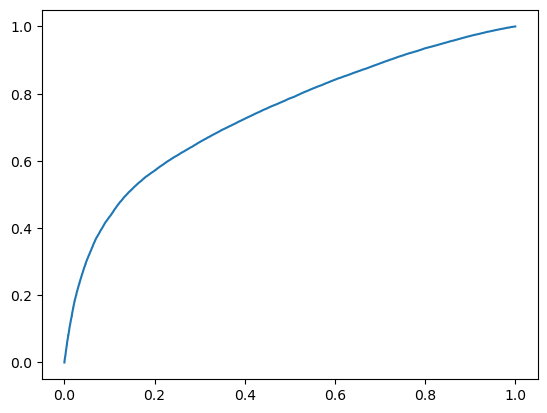

In [40]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds =roc_curve(y_test['target'], X_test['scores'])
plt.plot(fpr, tpr)

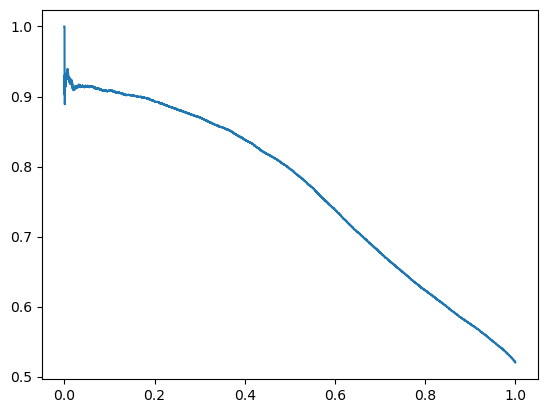

In [41]:

y, x, thr = precision_recall_curve(y_test['target'], X_test['scores'])
plt.plot(x, y)

<Axes: >

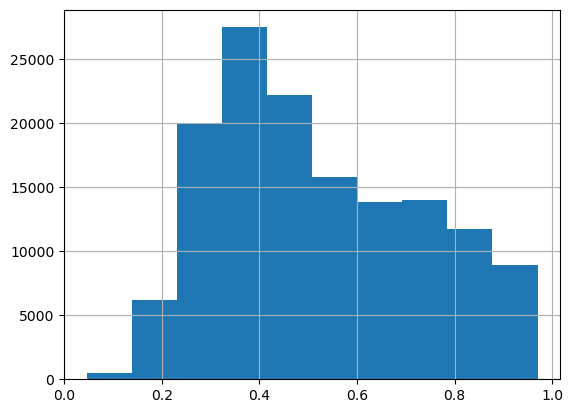

In [42]:
pd.Series(X_test['scores']).hist()

<Axes: >

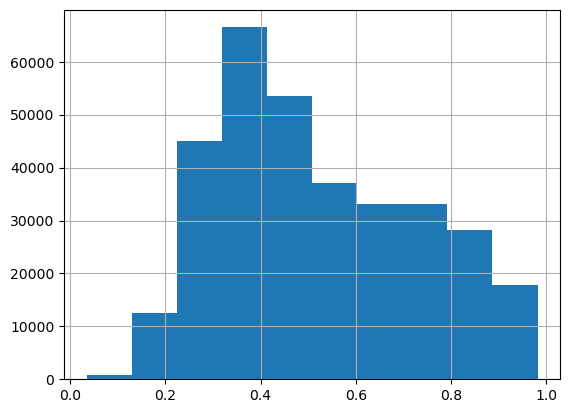

In [43]:
pd.Series(X_train['scores']).hist()

<Axes: >

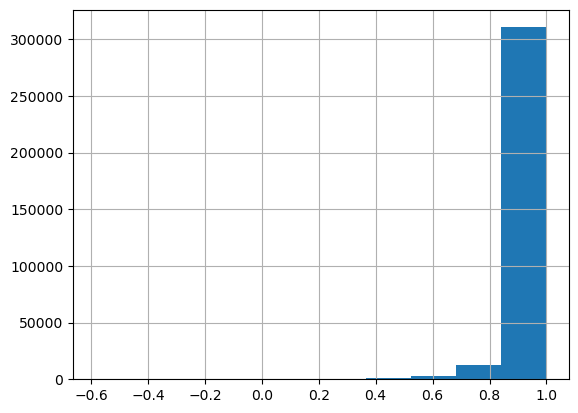

In [44]:
X_train.cos_sim.hist()

In [182]:
X_train = X_train.merge(data[['target', 'variantid1', 'variantid2']], right_index = True, left_index = True)
X_test = X_test.merge(data[['target']], right_index = True, left_index = True)

In [183]:
pd.set_option('display.max_rows', 100)

In [197]:
X_test[X_test.category==211].target.value_counts()

1    33557
0     3119
Name: target, dtype: int64

In [34]:
# X_test[[ 'target', 'scores','cos_sim', 'category', 'cat_dif',  'variantid1', 'variantid2', ]].iloc[37000:37100] #[(X_test.scores>0.9)]
#  #'cos_sim', 'category', (X_test.category==211)&

# Submission

In [45]:
#test_pairs = pd.read_parquet("../datasets/test_pairs_wo_target.parquet")
test_pairs = pd.read_csv("files/datasets/test_for_participants.csv")
test_etl = pd.read_parquet("files/datasets/test_data.parquet")

In [41]:
tr = list(set(test_pairs.variantid1.to_list()+test_pairs.variantid2.to_list()))
data[data.variantid1.isin(tr)].shape, len(tr)

((2889, 39), 35724)

In [46]:
tr_test = test_etl.categories.apply(lambda x: eval(x))
trim_test = pd.DataFrame(tr_test.to_list()).rename(columns={str(i):f'cat_{i}' for i in range(1, 5)})
trim_test['cat_2_en'] = trim_test.cat_2.map(dikt_cat_2)
trim_test['cat_3_en'] = trim_test.cat_3.map(dikt_cat_3)
trim_test['cat_4_en'] = trim_test.cat_4.map(dikt_cat_4)
trim_test = trim_test.merge(st, left_on = ['cat_2_en', 'cat_3_en', 'cat_4_en'], right_on = ['cat_2', 'cat_3', 'cat_4'], how = 'left')
test_etl['cat_encoded'] = trim_test['encoder']

In [39]:
# test_etl["cat3"] = test_etl["categories"].apply(lambda x: json.loads(x)["3"])
# cat3_counts = test_etl["cat3"].value_counts().to_dict()
# test_etl["cat3_grouped"] = test_etl["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")
# dikt_categories= {i: j for i, j in zip(test_etl.cat3_grouped.unique(), np.arange(test_etl.cat3_grouped.nunique())/test_etl.cat3_grouped.nunique())}
# test_etl['category_encoded'] = test_etl.cat3_grouped.map(dikt_categories)

In [47]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64']
symm_goods_pairs_test = symm_pairs(test_pairs)
dataset_test = ContrastiveDataset(test_etl, symm_goods_pairs_test, embedding_columns, mode = False)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=False, drop_last= False, num_workers =2)

In [48]:
yt = next(iter(test_dataloader))

In [49]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, test_dataloader)

        


  0%|          | 0/280 [00:00<?, ?it/s]

In [50]:
embed_test = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})
classif_test = test_pairs.merge(embed_test, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])
classif_test = classif_test.merge(embed_test, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])
classif_test.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [51]:
classif_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18086 entries, 0 to 18085
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   variantid1  18086 non-null  int64 
 1   variantid2  18086 non-null  int64 
 2   embed       18086 non-null  object
 3   embed_2     18086 non-null  object
dtypes: int64(2), object(2)
memory usage: 706.5+ KB


In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
     
    embed= list(np.abs(np.array(main_pic_embeddings_1)[None, ...] - np.array(main_pic_embeddings_2)[None, ...])[0])

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
    )[0][0]
    

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [52]:

classif_test[["embed_dif", "cos_sim", ]] = (
    classif_test[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features(*x)), axis=1
    )
)

In [53]:
classif_test = classif_test.merge(test_etl[['variantid', 'categories','cat_encoded' ]], left_on = 'variantid1', right_on = 'variantid', how = 'left', suffixes = ['', '_1'])
classif_test = classif_test.merge(test_etl[['variantid', 'cat_encoded']], left_on = 'variantid2', right_on = 'variantid', how = 'left', suffixes = ['', '_2'])
classif_test["cat3"] = classif_test["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif_test["cat3"].value_counts().to_dict()


In [54]:
classif_test["cat3_grouped"] = classif_test["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [55]:
def get_cat_diff(x, y):
    if not np.isnan(x) and not np.isnan(y):
        return (len(nx.bidirectional_shortest_path(G, int(x), int(y)))-1)//2
    else: return 0

In [56]:
classif_test['cat_dif'] = classif_test[['cat_encoded', 'cat_encoded_2']].apply(lambda x: get_cat_diff(*x), axis = 1)

In [57]:
dikt_categories= {i: j for i, j in zip(sorted(classif_test.cat_encoded.unique()), range(1, classif_test.cat_encoded.nunique()+1))}
classif_test['category'] = classif_test.cat_encoded.map(dikt_categories)
classif_test.category = np.where(classif_test.cat3_grouped=='rest', 0, classif_test.category)
embeddings = pd.DataFrame(classif_test['embed_dif'].tolist())
data_test = pd.concat([classif_test, embeddings], axis = 1)

In [58]:
data_test= data_test[['variantid1', 'variantid2',  'cos_sim', 'cat_dif']+list(embeddings.columns)] #'category'

In [63]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18086 entries, 0 to 18085
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   variantid1  18086 non-null  int64  
 1   variantid2  18086 non-null  int64  
 2   cos_sim     18086 non-null  float64
 3   category    18086 non-null  float64
 4   cat_dif     18086 non-null  int64  
 5   0           18086 non-null  float64
 6   1           18086 non-null  float64
 7   2           18086 non-null  float64
 8   3           18086 non-null  float64
 9   4           18086 non-null  float64
 10  5           18086 non-null  float64
 11  6           18086 non-null  float64
 12  7           18086 non-null  float64
 13  8           18086 non-null  float64
 14  9           18086 non-null  float64
 15  10          18086 non-null  float64
 16  11          18086 non-null  float64
 17  12          18086 non-null  float64
 18  13          18086 non-null  float64
 19  14          18086 non-nul

In [59]:
data_test['scores'] = model_cat.predict_proba(data_test)[:, 1]

In [60]:
submit = data_test[['variantid1', 'variantid2', 'scores']]

In [67]:
submit.to_csv('submition_last_2.csv', index=False, sep = ',')

In [134]:
import os
os.getcwd()

'/home/andreychuk/files/Ozon_marketplace'

In [68]:
from IPython.display import FileLink
FileLink(r'submition_last_2.csv')

/kaggle/working/submition_last_2.csv

In [69]:
submit.iloc[0:10]

,variantid1,variantid2,scores
0,372065731,372070671,0.245129
1,528068358,533445916,0.775272
2,480899084,480899989,0.437932
3,384479474,488458602,0.641282
4,658044199,663187587,0.453200
5,493237195,586331820,0.726240
6,91745099,688358377,0.664211
7,490146943,490147371,0.714015
8,510093774,510095318,0.762048
9,392063532,392068148,0.731360


In [64]:
submit.iloc[20:30]

,variantid1,variantid2,scores
20,210958678,688810962,0.309472
21,91252029,372070237,0.418264
22,369559923,691018275,0.522833
23,492572120,574224902,0.348003
24,670030473,670036940,0.636290
25,192617707,381396908,0.813606
26,670121173,670131962,0.542965
27,685395088,685395675,0.301698
28,412809736,663902855,0.410464
29,409131960,591692981,0.207332


<Axes: >

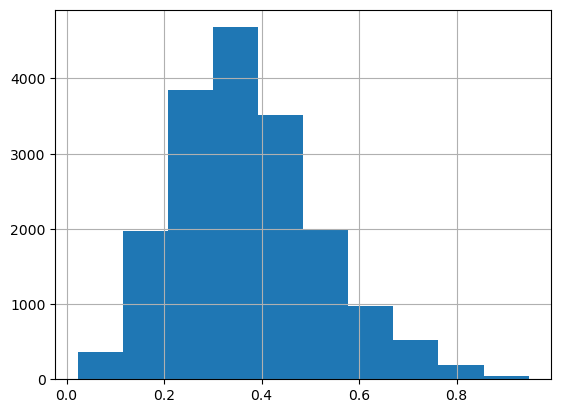

In [63]:
submit.scores.hist()